**Libraries To Import**
***

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,RocCurveDisplay,roc_curve, auc
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier

**Date Preprocessing**
***

In [2]:
data=pd.read_csv("spam.csv",encoding='windows-1252')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [3]:
# Drop Irrelevant Columns
data=data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)

In [4]:
#Calculate and Print the Missing Values
missing_values = data.isnull().sum()
print(missing_values)

v1    0
v2    0
dtype: int64


In [5]:
#Calculate and Print the Missing Values
print("Data Before Dropping Duplicated Values",data.duplicated().sum())

data.drop_duplicates(inplace=True)

print("Data after Dropping Duplicated Values",data.duplicated().sum())

Data Before Dropping Duplicated Values 403
Data after Dropping Duplicated Values 0


In [6]:
#Renaming Cloumns

data.info()
data.columns=['label','message']

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5169 non-null   object
 1   v2      5169 non-null   object
dtypes: object(2)
memory usage: 121.1+ KB


In [7]:
#Incoding Data (Label (spam,Ham))

label_encoder = LabelEncoder()
data['label']= label_encoder.fit_transform(data['label'])

y=data['label']

In [8]:
#Incoding Data (Message)

vectorizer = TfidfVectorizer()
x= vectorizer.fit_transform(data['message'])


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5169 non-null   int64 
 1   message  5169 non-null   object
dtypes: int64(1), object(1)
memory usage: 121.1+ KB


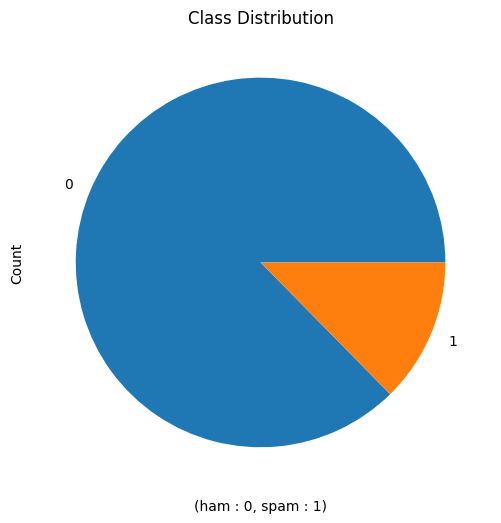

In [10]:
# Check class distribution
plt.figure(figsize=(8,6))
data['label'].value_counts().plot(kind='pie')
plt.title('Class Distribution')
plt.xlabel('(ham : 0, spam : 1)')
plt.ylabel('Count')
plt.show()


In [11]:
# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [12]:
# Define base models for stacking
base_models = [
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),  # Decision Tree
    ('knn', KNeighborsClassifier(n_neighbors=5)),                 # KNN
    ('svm', SVC(probability=True, kernel='linear', random_state=42))  # SVM
]

# Define the meta-learner (final model)
meta_learner = LogisticRegression()

# Create the Stacking model
stacking_model = StackingClassifier(
    estimators=base_models,  # Base models
    final_estimator=meta_learner,  # Meta model
    passthrough=False,  # Use original features + predictions from base models
    cv=5  # Cross-validation
)

# Train the Stacking model on the training data
stacking_model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('dt',
                                DecisionTreeClassifier(max_depth=5,
                                                       random_state=42)),
                               ('knn', KNeighborsClassifier()),
                               ('svm',
                                SVC(kernel='linear', probability=True,
                                    random_state=42))],
                   final_estimator=LogisticRegression())

In [13]:
# Make predictions on the test set
y_pred_stacking = stacking_model.predict(X_test)

# Compute Accuracy
stacking_accuracy = accuracy_score(y_test, y_pred_stacking)

#confussion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_stacking)
print("\nConfusion Matrix:\n")
print(conf_matrix)

print("\n--------------\n")

print(f"Accuracy of Stacking : {stacking_accuracy * 100:.2f} %")


Confusion Matrix:

[[886   3]
 [ 10 135]]

--------------

Accuracy of Stacking : 98.74 %


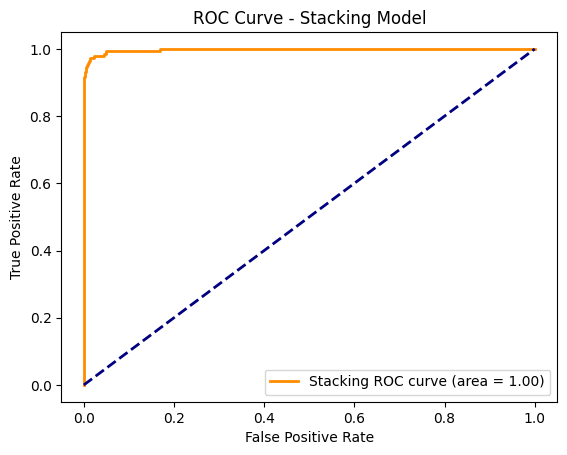

In [22]:
y_proba = stacking_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Stacking ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

In [14]:

# Create XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=100,   # Number of trees
    learning_rate=0.1,  # Step size shrinkage (controls impact of each tree)
    max_depth=3,        # Maximum depth of each tree
    random_state=42,
    eval_metric="mlogloss"  # Multi-class log loss
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)


In [15]:

# Calculate accuracy
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)

#confussion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
print("\nConfusion Matrix:\n")
print(conf_matrix)

print("\n--------------\n")

# Print results
print(f"✅ Accuracy using XGBoost: {xgb_accuracy*100:.2f} %")


Confusion Matrix:

[[883   6]
 [ 29 116]]

--------------

✅ Accuracy using XGBoost: 96.62 %


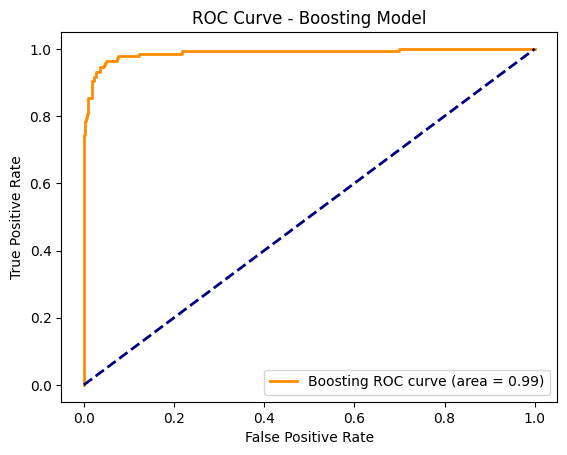

In [26]:
y_proba =xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Boosting ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Boosting Model')
plt.legend(loc="lower right")
plt.show()

In [16]:
# Create a Bagging model using Decision Tree
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),  # Base model (Decision Tree)
    n_estimators=10,  # Number of estimators (trees)
    max_samples=0.8,  # Percentage of data used per model
    bootstrap=True,  # Enable bootstrapping (sampling with replacement)
    random_state=42
)

In [17]:
# Train the Bagging model on the training data
bagging_model.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=0.8,
                  random_state=42)

In [18]:
# Make predictions on the test set
y_pred_bagging = bagging_model.predict(X_test)

# Compute Accuracy
bagging_accuracy = accuracy_score(y_test, y_pred_bagging)

#confussion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_bagging)
print("\nConfusion Matrix:\n")
print(conf_matrix)

print("\n--------------\n")


# Print results
print(f"✅ Accuracy of Bagging with 10 Trees: {bagging_accuracy*100:.2f} %")


Confusion Matrix:

[[883   6]
 [ 23 122]]

--------------

✅ Accuracy of Bagging with 10 Trees: 97.20 %


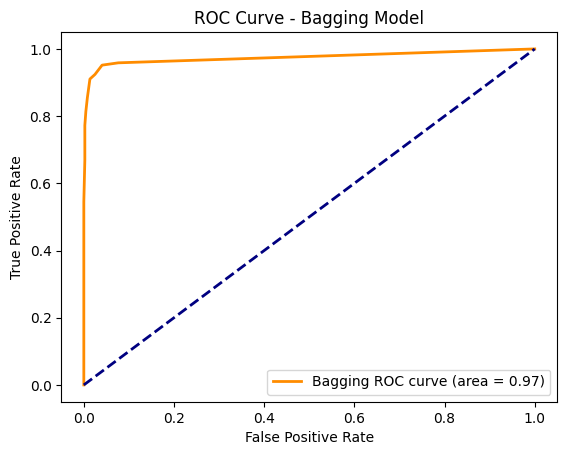

In [25]:
y_proba = bagging_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Bagging ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Bagging Model')
plt.legend(loc="lower right")
plt.show()

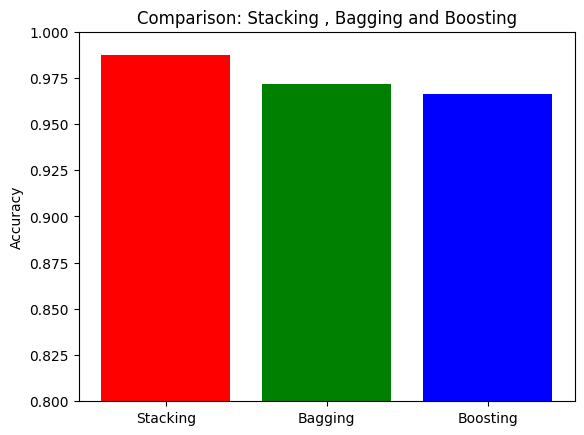

In [19]:
# Performance comparison
labels = ['Stacking','Bagging','Boosting']
accuracies = [stacking_accuracy,bagging_accuracy,xgb_accuracy]

plt.bar(labels, accuracies, color=['red', 'green','blue'])
plt.ylabel('Accuracy')
plt.title('Comparison: Stacking , Bagging and Boosting')
plt.ylim(0.8, 1)  # Adjust scale
plt.show()

**Interaction Function**
***

In [21]:
def classify_message():
    
    print("SPAM/HAM CLASSIFIER")
    print("-------------------")
    print("This classifier uses a Stacking ensemble of Decision Tree, KNN, and SVM models.")
    print("Enter 'quit' to exit.\n")

    while True:
        message = input("Enter a message to classify (or 'quit' to exit): ")

        if message.lower() == 'quit':
            print("\nExiting classifier...")
            break

        if not message.strip():
            print("Please enter a valid message.\n")
            continue

        # Vectorize the input message
        message_vector = vectorizer.transform([message])

        # Make prediction
        prediction = stacking_model.predict(message_vector)
        probability = stacking_model.predict_proba(message_vector)

        # Get class label
        if prediction[0] == 1:
            label = "SPAM"
            confidence = probability[0][1] * 100
        else:
            label = "HAM"
            confidence = probability[0][0] * 100
        print("this is the text:",message)
        print(f"\nClassification: {label}")
        print(f"Confidence: {confidence:.2f}%")
        print(f"Details: [SPAM probability: {probability[0][1]:.4f}, HAM probability: {probability[0][0]:.4f}]\n")

# Run the interactive classifier
classify_message()

SPAM/HAM CLASSIFIER
-------------------
This classifier uses a Stacking ensemble of Decision Tree, KNN, and SVM models.
Enter 'quit' to exit.

this is the text: "Urgent! Your bank account has been suspended. Click here to verify your details: http://fake-bank-site.com"

Classification: SPAM
Confidence: 93.16%
Details: [SPAM probability: 0.9316, HAM probability: 0.0684]

this is the text: "Hey, are we still meeting for lunch at 1 PM today?"

Classification: HAM
Confidence: 98.89%
Details: [SPAM probability: 0.0111, HAM probability: 0.9889]

this is the text: "Your Windows PC is infected! Call +1-XXX-XXX-XXXX immediately to fix it."

Classification: SPAM
Confidence: 86.39%
Details: [SPAM probability: 0.8639, HAM probability: 0.1361]

this is the text: "Your OTP for login is 7849. Do not share it with anyone."

Classification: HAM
Confidence: 98.80%
Details: [SPAM probability: 0.0120, HAM probability: 0.9880]

this is the text: qiut

Classification: HAM
Confidence: 98.79%
Details: [SPAM p